In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
seed_constant = 0
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
!unzip all-videos.zip

Archive:  all-videos.zip
   creating: all-videos/ArmFlapping/
  inflating: all-videos/ArmFlapping/ArmFlapping_1.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_10.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_11.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_12.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_13.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_14.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_15.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_16.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_17.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_18.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_19.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_2.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_20.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_21.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_22.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_23.mp4  
  inflating: all-videos/ArmF

In [4]:
# plt.figure(figsize = (20, 20))

# class_names = ["ArmFlapping", "HeadBanging"]

# # Iterating through all the generated random values.
# for counter, selected_class_Name in enumerate(class_names):
#     # Retrieve the list of all the video files present in the randomly selected Class Directory.
#     video_files_names_list = os.listdir(f'all-videos/{selected_class_Name}')

#     # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
#     selected_video_file_name = random.choice(video_files_names_list)

#     # Initialize a VideoCapture object to read from the video File.
#     video_reader = cv2.VideoCapture(f'all-videos/{selected_class_Name}/{selected_video_file_name}')

#     # Read the first frame of the video file.
#     _, bgr_frame = video_reader.read()

#     # Release the VideoCapture object.
#     video_reader.release()

#     # Convert the frame from BGR into RGB format.
#     rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

#     # Write the class name on the video frame.
#     cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

#     # Display the frame.
#     plt.subplot(5, 4, counter + 1);plt.imshow(rgb_frame);plt.axis('off')

In [5]:
IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128

SEQUENCE_LENGTH = 60

DATASET_DIR = "all-videos"

CLASSES_LIST = ["ArmFlapping", "HeadBanging"]

In [6]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [7]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [8]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: ArmFlapping
Extracting Data of Class: HeadBanging


In [9]:
one_hot_encoded_labels = to_categorical(labels)

In [10]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels, test_size = 0.25,
    shuffle = True, random_state = seed_constant
)

In [11]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [12]:
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 60, 126, 126, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 60, 63, 63, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 60, 63, 63, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 60, 61, 61, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 60, 31, 31, 8)    0         
 3D)                                                             
                                                        

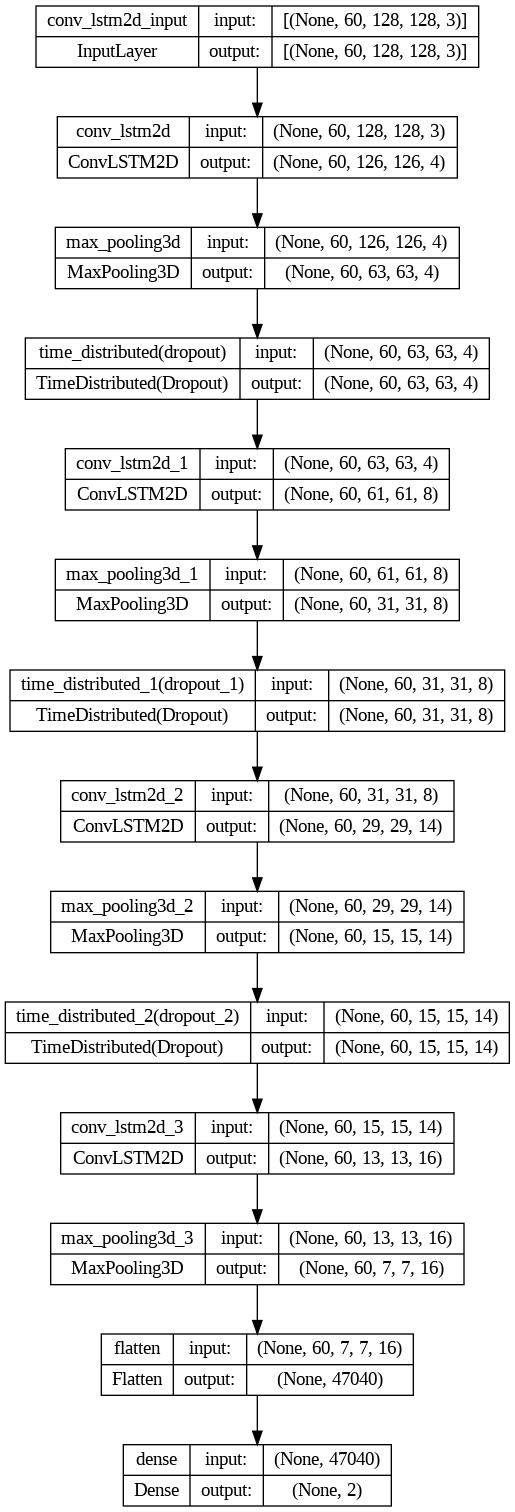

In [13]:
plot_model(
    convlstm_model, to_file = 'convlstm_model_structure_plot.png',
    show_shapes = True, show_layer_names = True
)

In [14]:
early_stopping_callback = EarlyStopping(
    monitor = 'val_loss', patience = 10,
    mode = 'min', restore_best_weights = True
)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'Adam',
    metrics = ["accuracy"]
)

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(
    x = features_train, y = labels_train, epochs = 50,
    batch_size = 4,shuffle = True, validation_split = 0.25,
    callbacks = [early_stopping_callback]
)

Epoch 1/50
3/3 [==============================] - 97s 26s/step - loss: 0.6226 - accuracy: 0.9091 - val_loss: 4.5248 - val_accuracy: 0.2500
Epoch 2/50
3/3 [==============================] - 80s 27s/step - loss: 2.1485 - accuracy: 0.3636 - val_loss: 0.5372 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 80s 27s/step - loss: 0.6297 - accuracy: 0.6364 - val_loss: 0.5066 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 83s 27s/step - loss: 0.5950 - accuracy: 0.6364 - val_loss: 0.4876 - val_accuracy: 0.7500
Epoch 5/50
3/3 [==============================] - 82s 26s/step - loss: 0.6409 - accuracy: 0.5455 - val_loss: 0.5663 - val_accuracy: 1.0000
Epoch 6/50
3/3 [==============================] - 77s 27s/step - loss: 0.4490 - accuracy: 0.8182 - val_loss: 0.3891 - val_accuracy: 1.0000
Epoch 7/50
3/3 [==============================] - 83s 28s/step - loss: 0.3467 - accuracy: 0.9091 - val_loss: 0.4354 - val_accuracy: 0.7500
Epoch 8/50
3/3 [===========

In [15]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

1/1 [==============================] - 12s 12s/step - loss: 3.2315 - accuracy: 0.8333


In [16]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

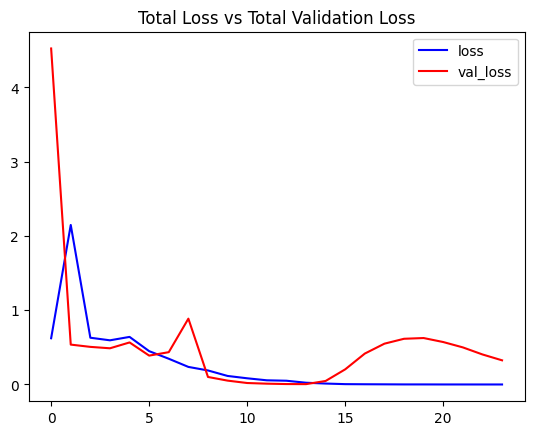

In [17]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

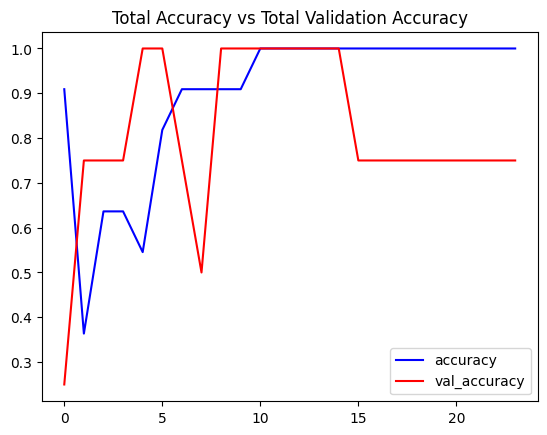

In [18]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')